In [1]:
# ignore warnings for better clarity (may not be the best thing to do)...
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing import sequence 
from keras.models import Sequential 
from keras.layers import Dense, Embedding 
from keras.layers import LSTM 
from numpy import sqrt
from numpy import concatenate
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error


Using TensorFlow backend.


In [3]:
print("tensorflow version %s (should be at least 0.12.1)" % tf.__version__)
print("keras version %s (should be at least 2.0.7)" % keras.__version__)

tensorflow version 2.0.0 (should be at least 0.12.1)
keras version 2.3.1 (should be at least 2.0.7)


## <font color=darkred> Data exploration </font>

In [6]:
# load dataset
raw_data = pd.read_csv('./pollution.csv', header=0, index_col=0)
values = raw_data.values    #return a numpy representation of the dataframe
print (raw_data.info())
print (raw_data.describe(include='all'))
values.shape

<class 'pandas.core.frame.DataFrame'>
Index: 43800 entries, 2010-01-02 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
pollution    43800 non-null float64
dew          43800 non-null int64
temp         43800 non-null float64
press        43800 non-null float64
wnd_dir      43800 non-null object
wnd_spd      43800 non-null float64
snow         43800 non-null int64
rain         43800 non-null int64
dtypes: float64(4), int64(3), object(1)
memory usage: 3.0+ MB
None
           pollution           dew          temp         press wnd_dir  \
count   43800.000000  43800.000000  43800.000000  43800.000000   43800   
unique           NaN           NaN           NaN           NaN       4   
top              NaN           NaN           NaN           NaN      SE   
freq             NaN           NaN           NaN           NaN   15290   
mean       94.013516      1.828516     12.459041   1016.447306     NaN   
std        92.252276     14.429326     12.193384     10.271411     NaN   

(43800, 8)

This dataset provides hourly weather conditions and pollution levels for  five years at the US embassy in Beijing, China.

The complete feature list in the raw data is as follows:

``No``: row number

``year``: year of data in this row

``month``: month of data in this row

``day``: day of data in this row

``hour``: hour of data in this row

``pm2.5``: PM2.5 concentration i.e. pollution level

``DEWP``: Dew Point

``TEMP``: Temperature

``PRES``: Pressure

``cbwd``: Combined wind direction

``Iws``: Cumulated wind speed

``Is``: Cumulated hours of snow

``Ir``: Cumulated hours of rain

In [5]:
raw_data.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


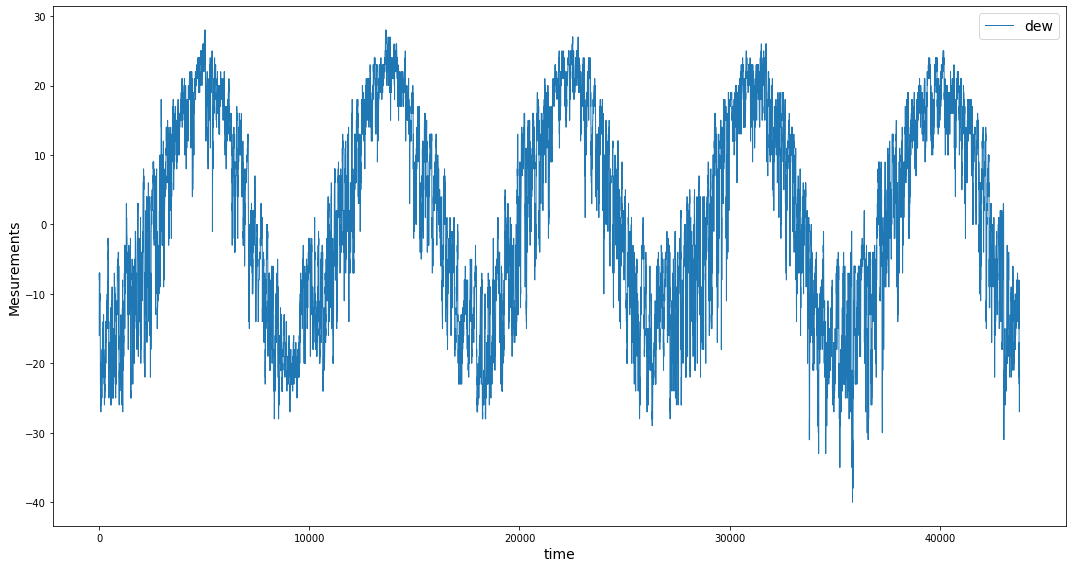

In [61]:
plt.figure(figsize=(15, 8))
plt.plot(values[:, 1], lw=1, label=raw_data.columns[1])    #values[:,1] : la colonne correspondant à Dew
plt.legend(fontsize=14)
plt.xlabel('time', fontsize=14)
plt.ylabel('Mesurements', fontsize=14)
plt.tight_layout()

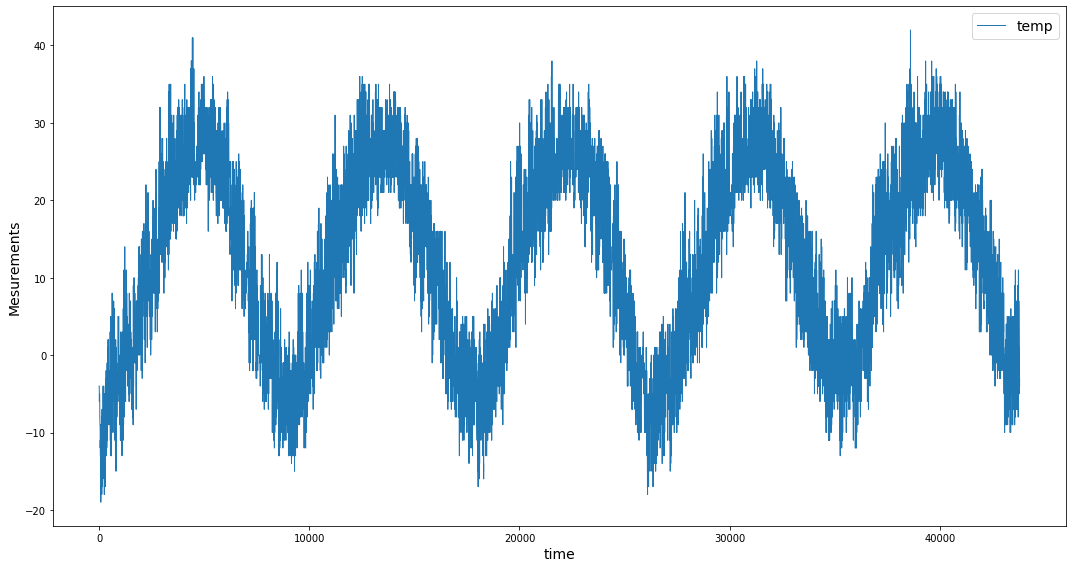

In [62]:
plt.figure(figsize=(15, 8))
plt.plot(values[:, 2], lw=1, label=raw_data.columns[2])  #values[:,2]=colonne correspondant à la température
plt.legend(fontsize=14)
plt.xlabel('time', fontsize=14)
plt.ylabel('Mesurements', fontsize=14)
plt.tight_layout()

**Questions**

Display the pollution level as a function of time.

Use the ``heatmap`` function to display the correlation of the data.

Display boxplots of the pollution values as a function of other variables values
(This may help to detect useless features for prediction).


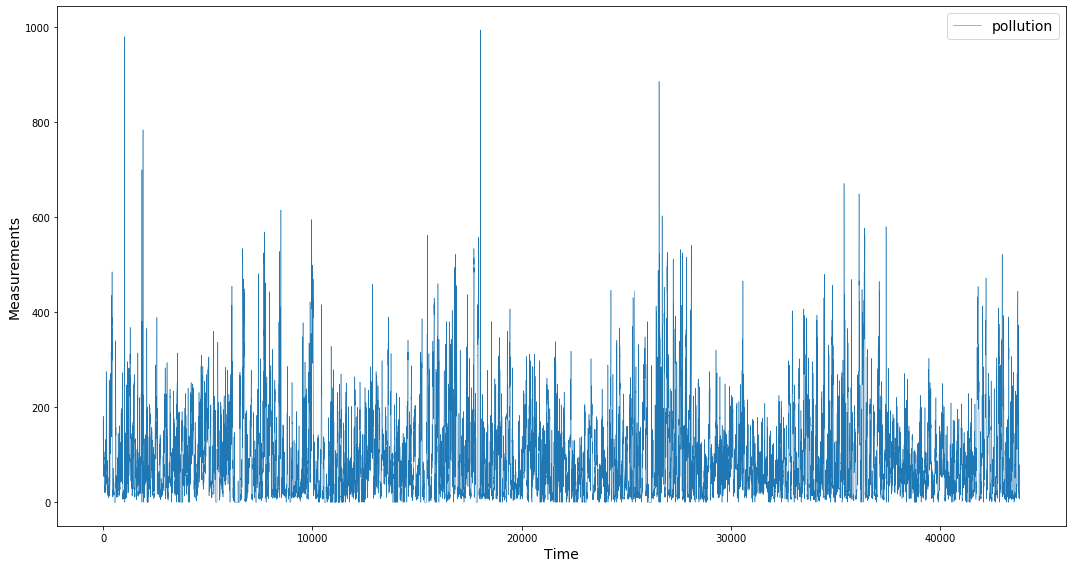

In [63]:
##
plt.figure(figsize=(15,8))
plt.plot(values[:,0], lw=0.5, label=raw_data.columns[0])
plt.legend(fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Measurements', fontsize=14)
plt.tight_layout()
##

           pollution       dew      temp     press   wnd_spd      snow  \
pollution   1.000000  0.157585 -0.090798 -0.045544 -0.234362  0.022226   
dew         0.157585  1.000000  0.824432 -0.778737 -0.296720 -0.034484   
temp       -0.090798  0.824432  1.000000 -0.827205 -0.154902 -0.092726   
press      -0.045544 -0.778737 -0.827205  1.000000  0.185380  0.069031   
wnd_spd    -0.234362 -0.296720 -0.154902  0.185380  1.000000  0.021876   

               rain  
pollution -0.049045  
dew        0.125053  
temp       0.049037  
press     -0.079840  
wnd_spd   -0.010137  


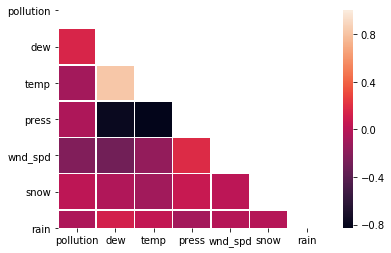

In [64]:
import seaborn as sns
corr = raw_data.corr()
##
# TO DO; display heatmap here and the head of the variable corr. 
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, mask=mask, linewidths=0.5)
print(corr.head())
##

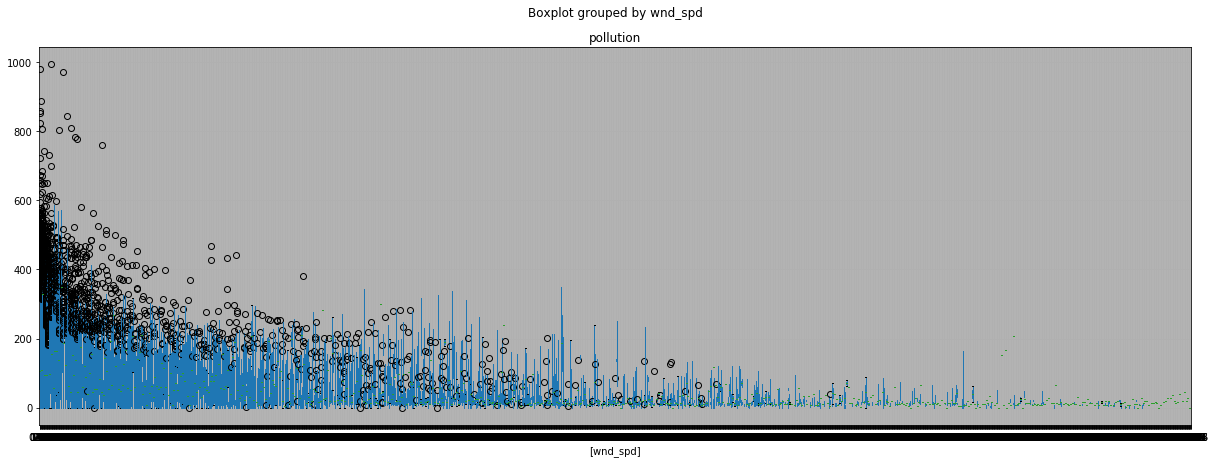

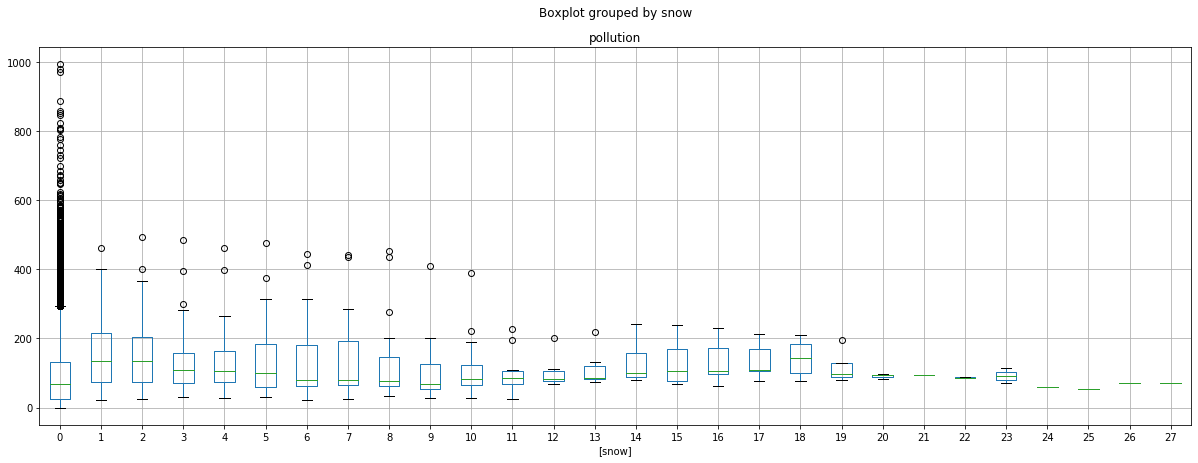

In [81]:
# some boxplots displaying the distribution of a feature within each category.
# This may help to detect useless features for classification... or a feature highly impacted by the category.
raw_data.boxplot('pollution', by=['rain'],figsize=(15,7))

##
# TO DO: display other boxplots as a function of other variables and comment the results
raw_data.boxplot('pollution', by=['dew'], figsize=(20,7))
raw_data.boxplot('pollution', by=['press'], figsize=(20,7))
plt.ylim(0,190)
raw_data.boxplot('pollution', by=['wnd_dir'], figsize=(20,7))
plt.ylim(10,180)
raw_data.boxplot('pollution', by=['wnd_spd'], figsize=(20,7))
raw_data.boxplot('pollution', by=['snow'], figsize=(20,7))
##

![](Boxplot.pluie.PNG)

When there is no rain, there is a high variability in the pollution level and lot's of outliers. When the density of rain is much higher, there are less variability in pollution, meaning that the two features pollution and rain are correlated.

![](Boxplot.dew.png)

It seems like when the dew point is very low, less than -6, the pollution level decreases when the dew point decreases and there is less variability in the pollution level as the first and third quartile are very close to the median. Between 0 and 20, it is difficult to analyse the correlation between pollution and dew point because there is the same number of outliers approximately and that the median and quartiles are quite similar. We can also spot that when it is above 20, there is less variability in the pollution level, it increases with the dew point (medians are skyrocketting from this value of dew point). So, the two features pollution and dew are correlated, but this correlation is visible with extreme values of the dew point. 

![](Boxplot.pression.png)
![](Boxplot.pression.zoom.png)

As the number of outlier is high and as the maximums are very high in comparison with the values of the medians, I chose to re-size the figure to better analyse the correlation. We can see that, like the dew point, the correlation is visible when the values of the pression are low and high. For instance, when pression is above a certain value, we can see that the median is becoming very low (underneath 25) and that the first and third quartiles become closer, with means that there is less variability is the pollution level. So, the two features pollution and pression are correlated. 

![](Boxplot.wind.dir.png)

This is difficult to make an analysis out of this boxplot because the wind direction is not quantitative. But by reducing the scale and without paying attention to the numerous outliers, we can state that there is less pollution when the wind's direction is North West, with the pollution median just above 25 comparing to the pollution median which is globally (considering every wind direction) at 68. So, the wind direction and pollution level are correlated. Looking at a map and the location of Beijing, it seems normal that a wind with North West direction is the one which leads to the less amount of pollution because the wind comes from the sea and carry less pollution than if it came from cities.

![](Boxplot.wind.speed.png)

When there is little wind speed or no wind at all, there is a high variability in the pollution level and lot's of outliers. When the speed of the wind is much higher, there are less variability in pollution, meaning that the two features pollution and wind speed are correlated, which confirms what seems obvious: the more windy it is, the less pollution there is (in fact, the maximums are less high when the speed of the wind increases. 

![](Boxplot.snow.png)

When there is no snow, there is a high variability in the pollution level and lot's of outliers. When the density of snow is much higher, there are less outliers and less variability in pollution (because the size of the boxes decreases), meaning that the two features pollution and snow are correlated. 

## <font color=darkred> Pre-processing </font>

Pre-processing from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

Design which data to use as inputs and which as outputs.

This function gets rid of NaN values.

It may be skipped during the first read. The only crucial feature is the ``n_in`` parameters which states the number of previous time steps to consider in the input data.

The objective of this project is to predict the pollution level $y_t$ at time $t$ from previous observations.
Simple recurrent neural networks and Long Short-Term memory will be considered. At each time step the estimate $\hat{y}_t$ is obtained using a hidden state $h_{t-1}$ computed on the fly and input data $x_t$ at time $t$. 

The function ``build_dataset`` provives the values of $y_t$ in the last column and the values of the input $x_t$ in all the other columns.

If $n_{in} = 1$, $x_t$ is made of all measurements at time $t-1$.

If $n_{in} = 2$, $x_t$ is made of all measurements at time $t-2$...

In [38]:
def build_dataset(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [47]:
# integer encode direction
encoder = preprocessing.LabelEncoder() #cette ligne permet de transformer les categorical variables en one-hot encoding ones
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# parameter to design how many time steps to consider in the input data
time_lag = 0
processed_data = build_dataset(scaled, time_lag, 1)
processed_data.head()

,var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
0,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0
1,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0
2,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0
3,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0


In [86]:
# split into train and test sets
values = processed_data.values  #values is a numpy representation of processed_data
val_copy = values.copy()
values[:,-1], values[:,-8] = val_copy[:,-8], val_copy[:,-1]

# number of years to use for training
nb_years = 3
n_train_hours = nb_years*365 * 24

train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1] #train_X takes all columns minus the last one which stands for the pollution level
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))


In [87]:
print('x_train shape:', train_X.shape)
print('x_test shape:', test_X.shape)
print('y_train shape:', train_y.shape)
print('y_test shape:', test_y.shape)

x_train shape: (26280, 1, 7)
x_test shape: (17520, 1, 7)
y_train shape: (26280,)
y_test shape: (17520,)


In [88]:
print(train_X.shape[0], 'train samples')
print(test_X.shape[0], 'test samples')

26280 train samples
17520 test samples


In [89]:
input_shape = (train_X.shape[1], train_X.shape[2])
input_shape

(1, 7)

## <font color=darkred> Feed Forward Neural Network </font>

In [90]:
from random import randint
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import activations
import numpy as np
from numpy import concatenate

import matplotlib.pyplot as plt

**Question**

Define a FFNN model with one hidden layer

In [91]:
model_ffnn = Sequential()

model_ffnn.add(Flatten(input_shape = input_shape))
model_ffnn.add(Dense(32, activation='relu'))
model_ffnn.add(Dense(1, activation='linear'))

model_ffnn.compile(
    loss='mae',
    optimizer=keras.optimizers.Adagrad(),
    metrics=['mean_squared_error']
)

model_ffnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 7)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                256       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________


In [92]:
batch_size = 64
epochs = 50
history = model_ffnn.fit(train_X, train_y,
                         batch_size=batch_size,
                         epochs=epochs,
                         verbose=1,
                         validation_data=(test_X, test_y))

Train on 26280 samples, validate on 17520 samples
Epoch 1/50
26280/26280 [==============================] - 1s 22us/step - loss: 0.0572 - mean_squared_error: 0.0073 - val_loss: 0.0591 - val_mean_squared_error: 0.0089
Epoch 2/50
26280/26280 [==============================] - 1s 19us/step - loss: 0.0548 - mean_squared_error: 0.0068 - val_loss: 0.0574 - val_mean_squared_error: 0.0080
Epoch 3/50
26280/26280 [==============================] - 0s 19us/step - loss: 0.0544 - mean_squared_error: 0.0066 - val_loss: 0.0576 - val_mean_squared_error: 0.0083
Epoch 4/50
26280/26280 [==============================] - 0s 19us/step - loss: 0.0542 - mean_squared_error: 0.0066 - val_loss: 0.0571 - val_mean_squared_error: 0.0080
Epoch 5/50
26280/26280 [==============================] - 0s 18us/step - loss: 0.0541 - mean_squared_error: 0.0066 - val_loss: 0.0572 - val_mean_squared_error: 0.0078
Epoch 6/50
26280/26280 [==============================] - 0s 18us/step - loss: 0.0540 - mean_squared_error: 0.0065 

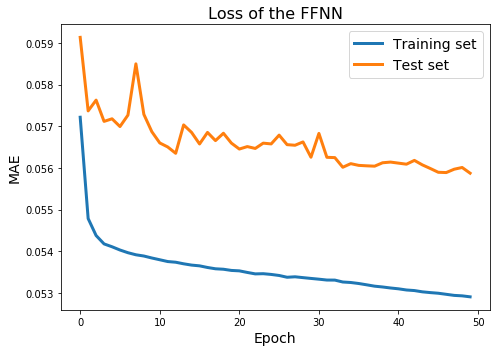

In [93]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['loss'], lw=3, label='Training set')
plt.plot(history.epoch, history.history['val_loss'], lw=3, label='Test set')
plt.legend(fontsize=14)
plt.title('Loss of the FFNN', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('MAE', fontsize=14)
plt.tight_layout()

## <font color=darkred> Recurrent Neural Networks</font>

At time $t$ the hidden state of the network is computed as follows:

$h_t = \sigma_h(W_x\,{x_t} + W_h\,{h_{t-1}} + b_h)$, where $\sigma_h$ is a nonlinear activation function, e.g. $\mathrm{tanh}$, $x_t$ is the input at time $t$ and $h_{t-1}$ is the hidden state at the previous time step.

$W_x$, $b_h$ and $W_h$ are the unknown parameters of the state update.

The predicted output is:

$\widehat{y}_t = \sigma_y(W_y\,{h_t} + b_y)\,,$

where $\sigma_y$ is the output activation function and $W_y$ and $b_y$ are the unknown parameters of the prediction step.

**Question**

Define a RNN model with one hidden layer ``SimpleRNN``

In [94]:
from keras.layers.recurrent import SimpleRNN
model_rnn = Sequential()

model_rnn.add(SimpleRNN(32,input_shape=(train_X.shape[1], train_X.shape[2])))  
model_rnn.add(Dense(1, activation='linear'))

model_rnn.compile(loss='mae', optimizer='adam')

model_rnn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 32)                1280      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 1,313
Trainable params: 1,313
Non-trainable params: 0
_________________________________________________________________


In [95]:
batch_size = 64
epochs = 50
history = model_rnn.fit(train_X, train_y, epochs = epochs, batch_size = batch_size, validation_data=(test_X, test_y), verbose=1)

Train on 26280 samples, validate on 17520 samples
Epoch 1/50
26280/26280 [==============================] - 1s 41us/step - loss: 0.0572 - val_loss: 0.0601
Epoch 2/50
26280/26280 [==============================] - 1s 29us/step - loss: 0.0557 - val_loss: 0.0587
Epoch 3/50
26280/26280 [==============================] - 1s 28us/step - loss: 0.0551 - val_loss: 0.0604
Epoch 4/50
26280/26280 [==============================] - 1s 27us/step - loss: 0.0557 - val_loss: 0.0576
Epoch 5/50
26280/26280 [==============================] - 1s 28us/step - loss: 0.0553 - val_loss: 0.0597
Epoch 6/50
26280/26280 [==============================] - 1s 28us/step - loss: 0.0553 - val_loss: 0.0598
Epoch 7/50
26280/26280 [==============================] - 1s 29us/step - loss: 0.0552 - val_loss: 0.0585
Epoch 8/50
26280/26280 [==============================] - 1s 28us/step - loss: 0.0552 - val_loss: 0.0592
Epoch 9/50
26280/26280 [==============================] - 1s 28us/step - loss: 0.0552 - val_loss: 0.0587
Epoch

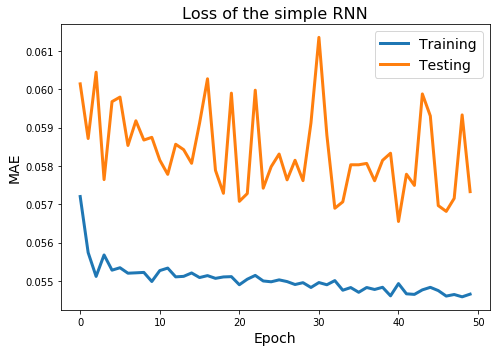

In [96]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['loss'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_loss'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Loss of the simple RNN', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('MAE', fontsize=14)
plt.tight_layout()

## <font color=darkred> Long Short-Term memory </font>

The LSTM cell is a more complex recurrent neural network. It contains three gates, input, forget, output gates and a memory cell i.e. several hidden transformations to process the hidden state and the input. 

The first transforms at time $t$ are: 

$i_t = \sigma ( W_i [h_{t-1}, x_t] + b_i)$, $f_t = \sigma ( W_f [h_{t-1},x_t] + b_f)$, $o_t = \sigma ( W_o [h_{t-1},x_t] + b_o)$,

where $W_i, W_f, W_o$, $b_i$, $b_f$ and $b_o$ are the unknown parameters (applied to the concatenation of $h_{t-1}$ (hidden state vector) and $x_t$ (input vector)).

The previous hidden state $h_{t-1}$ and the current input $x_t$ are used to compute the a candidate $g_t$:

$g_t = \mathrm{tanh}( W_g [h_{t-1}, x_t] + b_g)\,.$

The cell memory $c_t$, is updated as:

$c_t = c_{t-1} \circ f_t + g_t \circ i_t\,,$

where $c_{t-1}$ is the previous memory, and $\circ$ refers to element-wise multiplication.

The output, $h_t$, is computed as

$h_t = \mathrm{tanh}(c_t) \circ o\,.$

The predicted output is:

$\widehat{y}_t = \sigma_y(W_y\,{h_t} + b_y)\,,$

where $\sigma_y$ is the output activation function and $W_y$ and $b_y$is the unknown parameter of the prediction step.

**Question**

Define a LSTM model with one hidden layer

In [97]:
model = Sequential()
##
# TO DO: add the hidden layer of the LSTM
##
model.add(LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [98]:
batch_size = 64
epochs = 50
history = model.fit(train_X, train_y, epochs = epochs, batch_size = batch_size, validation_data=(test_X, test_y), verbose=1)

Train on 26280 samples, validate on 17520 samples
Epoch 1/50
26280/26280 [==============================] - 1s 51us/step - loss: 0.0577 - val_loss: 0.0596
Epoch 2/50
26280/26280 [==============================] - 1s 33us/step - loss: 0.0553 - val_loss: 0.0578
Epoch 3/50
26280/26280 [==============================] - 1s 32us/step - loss: 0.0548 - val_loss: 0.0575
Epoch 4/50
26280/26280 [==============================] - 1s 33us/step - loss: 0.0547 - val_loss: 0.0583
Epoch 5/50
26280/26280 [==============================] - 1s 33us/step - loss: 0.0546 - val_loss: 0.0578
Epoch 6/50
26280/26280 [==============================] - 1s 33us/step - loss: 0.0546 - val_loss: 0.0573
Epoch 7/50
26280/26280 [==============================] - 1s 34us/step - loss: 0.0545 - val_loss: 0.0574
Epoch 8/50
26280/26280 [==============================] - 1s 35us/step - loss: 0.0545 - val_loss: 0.0582
Epoch 9/50
26280/26280 [==============================] - 1s 32us/step - loss: 0.0544 - val_loss: 0.0581
Epoch

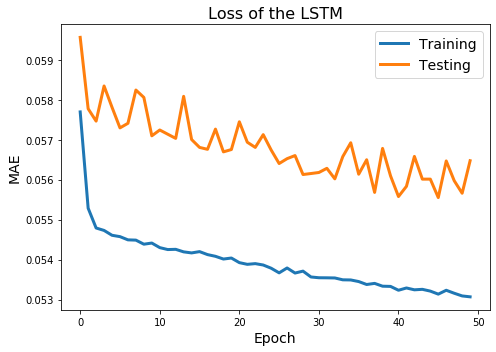

In [99]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['loss'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_loss'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Loss of the LSTM', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('MAE', fontsize=14)
plt.tight_layout()

**Questions**

Use a cross-validation to select the best LSTM and best RNN networks (with respect to the dimension of the hidden state) dimension.

Analyze the impact of the lag in the input sequence (i.e. if $x_t$ contains the features at times $t-1$, $t-2$, $t-3$) by using the function ``build_dataset`` with another parameter.

Analyze the sensitiviy of the LSTM with respect to initialization (by training several independent LSTM models).

Use the predict function to predict the observations $y$ associated with the input data in ``test_X``. Display these predictions with the true pollution level in ``y_test``. Compute the associated mean square error. 

The following function $data$ has the argument $time$_$lag$ and returns the training set (train_X and train_y) and the test set (test_X, test_y) according to the value of the time lag. As a matter of fact, when time lag increases by one, there are 8 more columns added to $values$ because all the features at the previous time are taken as inputs for the prediction. This function allows to have the pollution level at time $t$ always in the last column of $values$, and the input data in the other columns. Doing this, the prediction data (the pollution level at time $t$) is always at the same position in the numpy representation of $values$, even if the time_lag value changes.

In [194]:
from keras.layers.recurrent import SimpleRNN
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

def lstm_model(lstm_dim=4):
    model = Sequential()
    model.add(LSTM(lstm_dim, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    return (model)

def rnn_model(rnn_dim=4):
    model = Sequential()
    model.add(SimpleRNN(rnn_dim, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mae', optimizer='adam')
    return (model)

def data (time_lag): #time_lag = parameter to design how many time steps to consider in the input data 
    values = raw_data.values 
    
    processed_data = build_dataset(scaled, time_lag, 1)
    # split into train and test sets
    values = processed_data.values  #values is a numpy representation of processed_data, which is data normalized for prediction
    val = values.copy()
    values[:,-8], values[:,-1] = val[:,-1], val[:,-8]
    
    # number of years to use for training
    nb_years = 4
    n_train_hours = nb_years*365 * 24
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1] #train_X takes all columns minus the last one which stands for the pollution level
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    return(train_X, train_y, test_X, test_y)  



This following two cells are the cross-validation to select the best dimension of the hidden layer of a SimpleRNN and the one of a LSTM, when time lag considered is equal to 0 which means that the input data is made of all the features at time $t$ minus the pollution level at time $t$ which stands for the feature to predict. 

In [144]:
train_X, train_y, test_X, test_y = data(0)
estimator_rnn = KerasRegressor(build_fn=rnn_model, batch_size=64, epochs=50)
param_grid_rnn = {'rnn_dim': [4, 8, 16, 32, 64, 128, 256, 512]}
clf_rnn = GridSearchCV(estimator=estimator_rnn, param_grid=param_grid_rnn, n_jobs=-1, cv = 3)
clf_rnn.fit(train_X, train_y)

print("Best parameters set found on development set for the RNN cross-validation:")
print()
print(clf_rnn.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf_rnn.cv_results_['mean_test_score']
stds = clf_rnn.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_rnn.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

Epoch 1/50
35040/35040 [==============================] - 1s 25us/step - loss: 0.0624: 1s - lo
Epoch 2/50
35040/35040 [==============================] - 1s 18us/step - loss: 0.0564
Epoch 3/50
35040/35040 [==============================] - 1s 18us/step - loss: 0.0561
Epoch 4/50
35040/35040 [==============================] - 1s 20us/step - loss: 0.0559
Epoch 5/50
35040/35040 [==============================] - 1s 25us/step - loss: 0.0559
Epoch 6/50
35040/35040 [==============================] - 1s 23us/step - loss: 0.0559
Epoch 7/50
35040/35040 [==============================] - 1s 21us/step - loss: 0.0558
Epoch 8/50
35040/35040 [==============================] - 1s 23us/step - loss: 0.0558
Epoch 9/50
35040/35040 [==============================] - 1s 24us/step - loss: 0.0558
Epoch 10/50
35040/35040 [==============================] - 1s 24us/step - loss: 0.0558
Epoch 11/50
35040/35040 [==============================] - 1s 19us/step - loss: 0.0557
Epoch 12/50
35040/35040 [==================

In [145]:
train_X, train_y, test_X, test_y = data(0)
estimator_lstm = KerasRegressor(build_fn=lstm_model, batch_size=64, epochs=50)
param_grid_lstm = {'lstm_dim': [4, 8, 16, 32, 64, 128, 256, 512]}
clf_lstm = GridSearchCV(estimator=estimator_lstm, param_grid=param_grid_lstm, n_jobs=-1, cv = 3)
clf_lstm.fit(train_X, train_y)

print("Best parameters set found on development set for the LSTM cross-validation:")
print()
print(clf_lstm.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf_lstm.cv_results_['mean_test_score']
stds = clf_lstm.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_lstm.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

Epoch 1/50
35040/35040 [==============================] - 10s 281us/step - loss: 0.0574
Epoch 2/50
35040/35040 [==============================] - 11s 309us/step - loss: 0.0559
Epoch 3/50
35040/35040 [==============================] - 9s 257us/step - loss: 0.0558
Epoch 4/50
35040/35040 [==============================] - 9s 262us/step - loss: 0.0554
Epoch 5/50
35040/35040 [==============================] - 9s 260us/step - loss: 0.0551
Epoch 6/50
35040/35040 [==============================] - 10s 289us/step - loss: 0.0550
Epoch 7/50
35040/35040 [==============================] - 10s 278us/step - loss: 0.0547
Epoch 8/50
35040/35040 [==============================] - 10s 285us/step - loss: 0.0545
Epoch 9/50
35040/35040 [==============================] - 10s 290us/step - loss: 0.0544
Epoch 10/50
35040/35040 [==============================] - 11s 302us/step - loss: 0.0543
Epoch 11/50
35040/35040 [==============================] - 12s 340us/step - loss: 0.0542
Epoch 12/50
35040/35040 [========

So, the cross-validation results are the following ones : 
- for a Simple RNN, the optimal dimension of the hidden state is 4;
- for a LSTM, the optimal dimension is much higher : 512.
We should stand back from these results, as all the other hyperparameters are fixed. For instance the number of epochs is forced to 50 and the batch size is 64. We should obtain diferent results when doing a gridsearch where more hyperparameters are tested. This is the reason why the following cell is a grid search testing the influence of the input data dimension.

One other remark : I previously initialized the parameter $year$ in the $data()$ function to 3, so that the learning set was smaller, and I found that the optimal dimension for the hidden state is 16 for a Simple RNN and 128 for a LSTM. So, the split of the dataset into a training set and a validation set is very important because it has an impact over the dimension of the neural network to implement. 

This following two cells are the cross-valisation to select the best dimension of the hidden layer of a SimpleRNN and the one of a LSTM, when time lag considered varies from 1 to 3 which means that the input data is always diferent. This aims at showing whether there is or not a correaltion between the dimension of the hidden layer and the time lag considered (the volume of the input data). Here, the parameter refit of the $GridSearchCV$ function needs to be forced to $False$ because it is outside the loop. Otherwise, the estimator would be refited using the best found parameters on the whole dataset, which would compromise the results. 

In [151]:
estimator_rnn = KerasRegressor(build_fn=rnn_model, batch_size=64, epochs=50)
param_grid_rnn = {'rnn_dim':[4, 8, 16, 32, 64, 128]}
clf_rnn_test=GridSearchCV(estimator=estimator_rnn, param_grid=param_grid_rnn, n_jobs=-1, cv=3, refit=False)

for i in range (1,4):
    time_lag=i
    train_X, train_y, test_X, test_y = data(time_lag)
    clf_rnn_test.fit(train_X, train_y)
    print("For time_lag = %s :" %(time_lag))
    print("Best parameters set found on development set for a time lag equal to %s:" %time_lag)
    print()
    print(clf_rnn_test.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf_rnn_test.cv_results_['mean_test_score']
    stds = clf_rnn_test.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf_rnn_test.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()
    print("=============================================")
    print()

For time_lag = 1 :
Best parameters set found on development set for a time lag equal to 1:

{'rnn_dim': 16}

Grid scores on development set:

-0.014 (+/-0.001) for {'rnn_dim': 4}
-0.014 (+/-0.001) for {'rnn_dim': 8}
-0.014 (+/-0.001) for {'rnn_dim': 16}
-0.014 (+/-0.001) for {'rnn_dim': 32}
-0.014 (+/-0.001) for {'rnn_dim': 64}
-0.014 (+/-0.001) for {'rnn_dim': 128}


For time_lag = 2 :
Best parameters set found on development set for a time lag equal to 2:

{'rnn_dim': 8}

Grid scores on development set:

-0.014 (+/-0.001) for {'rnn_dim': 4}
-0.013 (+/-0.001) for {'rnn_dim': 8}
-0.014 (+/-0.002) for {'rnn_dim': 16}
-0.014 (+/-0.001) for {'rnn_dim': 32}
-0.014 (+/-0.001) for {'rnn_dim': 64}
-0.015 (+/-0.003) for {'rnn_dim': 128}


For time_lag = 3 :
Best parameters set found on development set for a time lag equal to 3:

{'rnn_dim': 4}

Grid scores on development set:

-0.013 (+/-0.001) for {'rnn_dim': 4}
-0.013 (+/-0.000) for {'rnn_dim': 8}
-0.014 (+/-0.001) for {'rnn_dim': 16}
-0.014

So, for a SimpleRNN, we can see that the time lag has influence over the optimal size of the hidden layer dimension. It seems that when the time lag increases, the optimal dimension of the hidden layer decreases (but this result is not valid when time lag equals 0). Here are the results summarized :  
- Time lag = 0 : When the input sequence contains the features at time t (all the features minus the pollution level at time t), then the optimal dimension of the hidden layer was, at the previous question, 4.
- Time lag = 1 : When the input sequence contains the features at time t (all the features minus the pollution level at time t) and all the features at time t-1, then the optimal dimension of the hidden layer is 16.
- Time lag = 2 : When the input sequence contains the features at time t (all the features minus the pollution level at time t) and all the features at time t-1 and t-2, then the optimal dimension of the hidden layer is 8.
- Time lag = 3 : When the input sequence contains the features at time t (all the features minus the pollution level at time t) and all the features at time t-1, t-2 and t-3, then the optimal dimension of the hidden layer is 4.


In [153]:
estimator_lstm = KerasRegressor(build_fn=lstm_model, batch_size=64, epochs=50)
param_grid_lstm = {'lstm_dim':[4, 8, 16, 32, 64, 128]}
clf_lstm_test=GridSearchCV(estimator=estimator_lstm, param_grid=param_grid_lstm, n_jobs=-1, cv=3, refit=False)

for i in range (1,4):
    time_lag=i
    train_X, train_y, test_X, test_y = data(time_lag)
    clf_lstm_test.fit(train_X, train_y)
    print("For time_lag = %s :" %(time_lag))
    print("Best parameters set found on development set for a time lag equal to %s:" %time_lag)
    print()
    print(clf_lstm_test.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf_lstm_test.cv_results_['mean_test_score']
    stds = clf_lstm_test.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf_lstm_test.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()
    print("=============================================")
    print()

For time_lag = 1 :
Best parameters set found on development set for a time lag equal to 1:

{'lstm_dim': 16}

Grid scores on development set:

-0.013 (+/-0.000) for {'lstm_dim': 4}
-0.013 (+/-0.000) for {'lstm_dim': 8}
-0.013 (+/-0.001) for {'lstm_dim': 16}
-0.013 (+/-0.001) for {'lstm_dim': 32}
-0.014 (+/-0.002) for {'lstm_dim': 64}
-0.014 (+/-0.001) for {'lstm_dim': 128}


For time_lag = 2 :
Best parameters set found on development set for a time lag equal to 2:

{'lstm_dim': 16}

Grid scores on development set:

-0.013 (+/-0.001) for {'lstm_dim': 4}
-0.014 (+/-0.000) for {'lstm_dim': 8}
-0.013 (+/-0.001) for {'lstm_dim': 16}
-0.013 (+/-0.000) for {'lstm_dim': 32}
-0.013 (+/-0.001) for {'lstm_dim': 64}
-0.013 (+/-0.001) for {'lstm_dim': 128}


For time_lag = 3 :
Best parameters set found on development set for a time lag equal to 3:

{'lstm_dim': 32}

Grid scores on development set:

-0.013 (+/-0.001) for {'lstm_dim': 4}
-0.013 (+/-0.001) for {'lstm_dim': 8}
-0.013 (+/-0.001) for {'l

So, for a LSTM, we can see that the time lag has little influence or no influence at all on the optimal size of the hidden layer dimension. Here are the results summarized :  
- Time lag = 0 : When the input sequence contains the features at time t (all the features minus the pollution level at time t), then the optimal dimension of the hidden layer was at the previous question 512.
- Time lag = 1 : When the input sequence contains the features at time t (all the features minus the pollution level at time t) and all the features at time t-1, then the optimal dimension of the hidden layer is 16.
- Time lag = 2 : When the input sequence contains the features at time t (all the features minus the pollution level at time t) and all the features at time t-1 and t-2, then the optimal dimension of the hidden layer is 16.
- Time lag = 3 : When the input sequence contains the features at time t (all the features minus the pollution level at time t) and all the features at time t-1, t-2 and t-3, then the optimal dimension of the hidden layer is 32.

This function aims at calculating the root mean square error between the prediction of the pollution at time $t$ and its real value. To do so, we need to inverse the processus of normalization of the features which was done to train the models. Then, the pollution predicted is in the vector $inv$_$yhat$ which dimension equals the one of $test$_$y$ and the real pollution is the vector $inv$_$y$. 

In [180]:
def calcul_rmse_lstm(test_X, test_y): 
    # make a prediction
    yhat = model_lstm_influence.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:,:]), axis=1) #concatenation column-wise
    inv_yhat = scaler.inverse_transform(inv_yhat) #the values were scaled before putting them into the neural networks, this operation makes the inverse operation so that the values are comprehensible
    inv_yhat = inv_yhat[:,0]

    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:,:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]

    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    rmse = rmse/len(test_y)
    return(rmse)

Let's now analyze the sensitiviy of the LSTM with respect to initialization (by training several independent LSTM models). As a matter of fact, the matrix of weight and the intercept are randomly initialized are then, it's the gradient descent algorithm that shapes them to fit the model the most properly.

In [199]:
train_X, train_y, test_X, test_y = data(0)
#print('Test RMSE: %.3f' % rmse)

L=[]
for i in range (0,3):
    model_lstm_influence = lstm_model(lstm_dim=512)
    model_lstm_influence.fit(train_X, train_y, epochs=50, batch_size=64, validation_data=(test_X, test_y), verbose=0)
    rmse = calcul_rmse_lstm(test_X, test_y)
    L.append(rmse)
print(L)

[0.00938409082421429, 0.009378124916390196, 0.009253903393331727]


Now let's see in comparison what is the influence of initialization on a Simple RNN.

In [183]:
def calcul_rmse_rnn(test_X, test_y): 
    # make a prediction
    yhat = model_rnn_influence.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:,:]), axis=1) #concatenation column-wise
    inv_yhat = scaler.inverse_transform(inv_yhat) #the values were scaled before putting them into the neural networks, this operation makes the inverse operation so that the values are comprehensible
    inv_yhat = inv_yhat[:,0]

    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:,:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]

    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    rmse = rmse/len(test_y)
    return(rmse)

train_X, train_y, test_X, test_y = data(0)
M=[]
for i in range (0,3):
    model_rnn_influence = rnn_model(rnn_dim=4)
    model_rnn_influence.fit(train_X, train_y, epochs=30, batch_size=64, validation_data=(test_X, test_y), verbose=0)
    rmse = calcul_rmse_rnn(test_X, test_y)
    M.append(rmse)
print(M)

Now let's see the graphical evolution of the real pollution level and the pollution level predicted. So that we could see wether prediction is good or not.

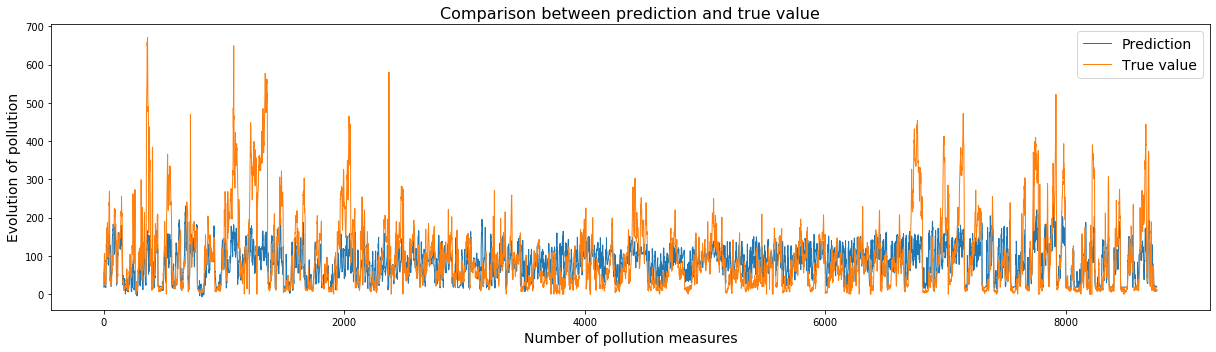

In [198]:
train_X, train_y, test_X, test_y = data(0)
model1_lstm = lstm_model(lstm_dim=512)
model1_lstm.fit(train_X, train_y, epochs=50, batch_size=64, validation_data=(test_X, test_y), verbose=0)

# make a prediction
yhat = model1_lstm.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:,:]), axis=1) #concatenation column-wise
inv_yhat = scaler.inverse_transform(inv_yhat) #the values were scaled before putting them into the neural networks, this operation makes the inverse operation so that the values are comprehensible
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:,:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

plt.figure(figsize=(17, 5))
plt.plot(inv_yhat, lw=1, label='Prediction')
plt.plot(inv_y, lw=1, label='True value')
plt.legend(fontsize=14)
plt.title('Comparison between prediction and true value', fontsize=16)
plt.xlabel('Number of pollution measures', fontsize=14)
plt.ylabel('Evolution of pollution', fontsize=14)
plt.tight_layout()

**Question (bonus)**

How would you capture the randomness of the prediction instead of producing a unique prediction at each time step ?

I think that as the RMSE are diferent depending on the randomness of the initialization of the LSTM, we can do the following thing : 
- compute the RMSE of many independant LSTM with the same hyper parameters;
- find the minimum of this RMSE;
- use the associated model for a better prediction. 